In [152]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 10

# 一、多因子选股策略 - 基于调仓表

In [1]:
import backtrader as bt
import pandas as pd
import datetime
import pyfolio as pf
import Path

# 回测策略
class StockSelectStrategy(bt.Strategy):
    '''多因子选股 - 基于调仓表'''
    def __init__(self):
        # 读取调仓表，表结构如下所示：
        #       trade_date  sec_code    weight
        # 0     2019-01-31  000006.SZ   0.007282
        # 1     2019-01-31  000008.SZ   0.009783
        # ...   ...         ...         ...
        # 2494  2021-01-28  688088.SH   0.007600
        self.buy_stock = pd.read_csv(Path("../bt_data/trade_info.csv"), parse_dates=['trade_date']) 
        # 读取调仓日期，即每月的最后一个交易日，回测时，会在这一天下单，然后在下一个交易日，以开盘价买入
        self.trade_dates = pd.to_datetime(self.buy_stock['trade_date'].unique()).tolist()
        self.order_list = []  # 记录以往订单，方便调仓日对未完成订单做处理
        self.buy_stocks_pre = [] # 记录上一期持仓
    

#     def log(self, txt, dt=None):
#         ''' 策略日志打印函数'''
#         dt = dt or self.datas[0].datetime.date(0)
#         print('%s, %s' % (dt.isoformat(), txt))

    def next(self):
        dt = self.datas[0].datetime.date(0) # 获取当前的回测时间点
        # 如果是调仓日，则进行调仓操作
        if dt in self.trade_dates:
            print("--------------{} 为调仓日----------".format(dt))
            # 在调仓之前，取消之前所下的没成交也未到期的订单
            if len(self.order_list) > 0:
                for od in self.order_list:
                    self.cancel(od) # 如果订单未完成，则撤销订单
                self.order_list = []  #重置订单列表
            # 提取当前调仓日的持仓列表
            buy_stocks_data = self.buy_stock.query(f"trade_date=='{dt}'")
            long_list = buy_stocks_data['sec_code'].tolist()
            print('long_list', long_list)  # 打印持仓列表
            # 对现有持仓中，调仓后不再继续持有的股票进行卖出平仓
            sell_stock = [i for i in self.buy_stocks_pre if i not in long_list]
            print('sell_stock', sell_stock) # 打印平仓列表
            if len(sell_stock) > 0:
                print("-----------对不再持有的股票进行平仓--------------")
                for stock in sell_stock:
                    data = self.getdatabyname(stock)
                    if self.getposition(data).size > 0 :
                        od = self.close(data=data)  
                        self.order_list.append(od) # 记录卖出订单
            # 买入此次调仓的股票：多退少补原则
            print("-----------买入此次调仓期的股票--------------")
            for stock in long_list:
                w = buy_stocks_data.query(f"sec_code=='{stock}'")['weight'].iloc[0] # 提取持仓权重
                data = self.getdatabyname(stock)
                order = self.order_target_percent(data=data, target=w*0.95) # 为减少可用资金不足的情况，留 5% 的现金做备用
                self.order_list.append(order)
       
            self.buy_stocks_pre = long_list  # 保存此次调仓的股票列表
        
    def notify_order(self, order):
        # 未被处理的订单
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 已经处理的订单
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(
                        'BUY EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                        (order.ref, # 订单编号
                         order.executed.price, # 成交价
                         order.executed.value, # 成交额
                         order.executed.comm, # 佣金
                         order.executed.size, # 成交量
                         order.data._name))  # 股票名称
            else:  # Sell
                self.log('SELL EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                            (order.ref,
                             order.executed.price,
                             order.executed.value,
                             order.executed.comm,
                             order.executed.size,
                             order.data._name))
        

# 实例化 cerebro
cerebro = bt.Cerebro()
# 读取行情数据 
daily_price = pd.read_csv("./data/daily_price.csv", parse_dates=['datetime'])
daily_price = daily_price.set_index(['datetime'])  # 将datetime设置成index
# 按股票代码，依次循环传入数据
for stock in daily_price['sec_code'].unique():
    # 日期对齐
    data = pd.DataFrame(index=daily_price.index.unique()) # 获取回测区间内所有交易日
    df = daily_price.query(f"sec_code=='{stock}'")[['open','high','low','close','volume','openinterest']]
    data_ = pd.merge(data, df, left_index=True, right_index=True, how='left')
    # 缺失值处理：日期对齐时会使得有些交易日的数据为空，所以需要对缺失数据进行填充
    data_.loc[:,['volume','openinterest']] = data_.loc[:,['volume','openinterest']].fillna(0)
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(method='pad')
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(0)
    # 导入数据
    datafeed = bt.feeds.PandasData(dataname=data_, 
                                   fromdate=datetime.datetime(2019,1,2), 
                                   todate=datetime.datetime(2021,1,28))
    cerebro.adddata(datafeed, name=stock) # 通过 name 实现数据集与股票的一一对应
#     print(f"{stock} Done !") 
# 初始资金 100,000,000    
cerebro.broker.setcash(100000000.0) 
# 佣金，双边各 0.0003
cerebro.broker.setcommission(commission=0.0003) 
# 滑点：双边各 0.0001
cerebro.broker.set_slippage_perc(perc=0.0001) 
# 将编写的策略添加给大脑，别忘了 ！
cerebro.addstrategy(StockSelectStrategy)
# 回测时需要添加 PyFolio 分析器
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
result = cerebro.run()
# 借助 pyfolio 进一步做回测结果分析

pyfolio = result[0].analyzers.pyfolio  # 注意：后面不要调用 .get_analysis() 方法
# 或者是 result[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio.get_pf_items()

print('----------------------------')
pf.create_full_tear_sheet(returns)

ModuleNotFoundError: No module named 'pyfolio'

# 二、多因子选股策略 - 直接指标选股

In [14]:
import backtrader as bt
import datetime
import pandas as pd

class PandasData_more(bt.feeds.PandasData):
    lines = ('ROE', 'EP', )  # 要添加的线
    # 设置 line 在数据源上的列位置
    params = dict(
        ROE=-1,  # 设置新增指标的位置，-1表示自动按列明匹配数据
        EP=-1
        )

class StockSelectStrategy(bt.Strategy):
    params = dict(
        selnum=30,  # 设置持仓股数在总的股票池中的占比，如买入表现最好的前30只股票
        rperiod=1,  # 计算收益率的周期
        vperiod=6,  # 计算波动率的周期，过去6个月的波动率
        mperiod=2,  # 计算动量的周期，如过去2个月的收益
        reserve=0.05  # 5% 为了避免出现资金不足的情况，每次调仓都预留 5% 的资金不用于交易
    )
    def log(self, arg):
        print('{} {}'.format(self.datetime.date(), arg))

    def __init__(self):
        # 计算持仓权重，等权
        self.perctarget = (1.0 - self.p.reserve) / self.p.selnum
        # 循环计算每只股票的收益波动率因子
        self.rs = {d:bt.ind.PctChange(d, period=self.p.rperiod) for d in self.datas}
        self.vs = {d:1/(bt.ind.StdDev(ret, period=self.p.vperiod)+0.000001) for d,ret in self.rs.items()}
        # 循环计算每只股票的动量因子
        self.ms = {d:bt.ind.ROC(d, period=self.p.mperiod) for d in self.datas}
        # 将 ep 和 roe 因子进行匹配
        self.EP = {d:d.lines.EP for d in self.datas}
        self.ROE = {d:d.lines.ROE for d in self.datas}
        self.all_factors = [self.rs, self.vs, self.ms, self.EP, self.ROE]
    
        
    def next(self):
        # 在每个横截面上计算所有因子的综合排名
        stocks = list(self.datas)
        ranks = {d:0 for d in stocks}
        # 计算每个因子的rank，并进行求和
        for factor in self.all_factors:
            stocks.sort(key=lambda x: factor[x][0], reverse=True)
            # print({x._name:factor[x][0] for x in stocks})
            ranks = {d:i+ranks[d] for d,i in zip(stocks, range(1,len(stocks)+1))}
            # print({d._name:rank for d,rank in ranks.items()})

        # 对各因子rank求和后的综合值进行最后的排序,最大综合值排最前面
        # 买入 动量、ep、roe 高；波动率低的股票
        ranks = sorted(ranks.items(), key=lambda x: x[1], reverse=False)  
        # print({i._name:rank for (i,rank) in ranks})

        # 选取前 self.p.selnum 只股票作为持仓股
        rtop = dict(ranks[:self.p.selnum])

        # 剩余股票将从持仓中剔除（如果在持仓里的话）
        rbot = dict(ranks[self.p.selnum:])

        # 提取有仓位的股票
        posdata = [d for d, pos in self.getpositions().items() if pos]

        # 删除不在继续持有的股票，进而释放资金用于买入新的股票
        for d in (d for d in posdata if d not in rtop):
            self.log('Leave {} - Rank {:.2f}'.format(d._name, rbot[d]))
            self.order_target_percent(d, target=0.0)

        # 对下一期继续持有的股票，进行仓位调整
        for d in (d for d in posdata if d in rtop):
            self.log('Rebal {} - Rank {:.2f}'.format(d._name, rtop[d]))
            self.order_target_percent(d, target=self.perctarget)
            del rtop[d]  

        # 买入当前持仓中没有的股票
        for d in rtop:
            self.log('Enter {} - Rank {:.2f}'.format(d._name, rtop[d]))
            self.order_target_percent(d, target=self.perctarget)
        


# 实例化 cerebro
cerebro = bt.Cerebro()
# 读取行情数据 
month_price = pd.read_csv("./data/month_price.csv", parse_dates=['datetime'])
month_price = month_price.set_index(['datetime']).sort_index()  # 将datetime设置成index
# 按股票代码，依次循环传入数据
for stock in month_price['sec_code'].unique():
    # 日期对齐
    data = pd.DataFrame(index=month_price.index.unique()) # 获取回测区间内所有交易日
    df = month_price.query(f"sec_code=='{stock}'")[['open','high','low','close','volume','openinterest']]
    data_ = pd.merge(data, df, left_index=True, right_index=True, how='left')
    # 缺失值处理：日期对齐时会使得有些交易日的数据为空，所以需要对缺失数据进行填充
    data_.loc[:,['volume','openinterest']] = data_.loc[:,['volume','openinterest']].fillna(0)
    data_.loc[:,['open','high','low','close','EP','ROE']] = data_.loc[:,['open','high','low','close']].fillna(method='pad')
    data_.loc[:,['open','high','low','close','EP','ROE']] = data_.loc[:,['open','high','low','close']].fillna(0.0000001)
    # 导入数据
    datafeed = PandasData_more(dataname=data_, 
                               fromdate=datetime.datetime(2019,1,31), 
                               todate=datetime.datetime(2021,8,31),
                               timeframe=bt.TimeFrame.Months) # 将数据的时间周期设置为月度
    cerebro.adddata(datafeed, name=stock) # 通过 name 实现数据集与股票的一一对应
    print(f"{stock} Done !") 
# 初始资金 100,000,000    
cerebro.broker.setcash(100000000.0) 
# 佣金，双边各 0.0003
cerebro.broker.setcommission(commission=0.0003) 
# 滑点：双边各 0.0001
cerebro.broker.set_slippage_perc(perc=0.0001) 
# 将编写的策略添加给大脑，别忘了 ！
cerebro.addstrategy(StockSelectStrategy)
# 返回收益率时序
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')
result = cerebro.run()
# 得到收益率时序
ret = pd.Series(result[0].analyzers._TimeReturn.get_analysis())

#########  注意  #########
# PyFolio 分析器返回的收益也是月度收益，但是绘制的各种收益分析图形会有问题，有些图绘制不出来


600671.SH Done !
002695.SZ Done !
603233.SH Done !
002666.SZ Done !
002550.SZ Done !
002696.SZ Done !
603238.SH Done !
002667.SZ Done !
002551.SZ Done !
002697.SZ Done !
603239.SH Done !
002668.SZ Done !
002552.SZ Done !
002698.SZ Done !
603258.SH Done !
603030.SH Done !
002640.SZ Done !
002669.SZ Done !
002553.SZ Done !
002699.SZ Done !
603259.SH Done !
603031.SH Done !
002641.SZ Done !
002670.SZ Done !
002549.SZ Done !
002554.SZ Done !
002665.SZ Done !
002694.SZ Done !
300712.SZ Done !
603000.SH Done !
600054.SH Done !
603088.SH Done !
002430.SZ Done !
002467.SZ Done !
300713.SZ Done !
603001.SH Done !
600055.SH Done !
002543.SZ Done !
002689.SZ Done !
002544.SZ Done !
002690.SZ Done !
002545.SZ Done !
002691.SZ Done !
002546.SZ Done !
002692.SZ Done !
603228.SH Done !
002547.SZ Done !
002693.SZ Done !
603229.SH Done !
002664.SZ Done !
002548.SZ Done !
603232.SH Done !
002700.SZ Done !
603260.SH Done !
603032.SH Done !
300630.SZ Done !
603038.SH Done !
002647.SZ Done !
300669.SZ Done

<IPython.core.display.Javascript object>

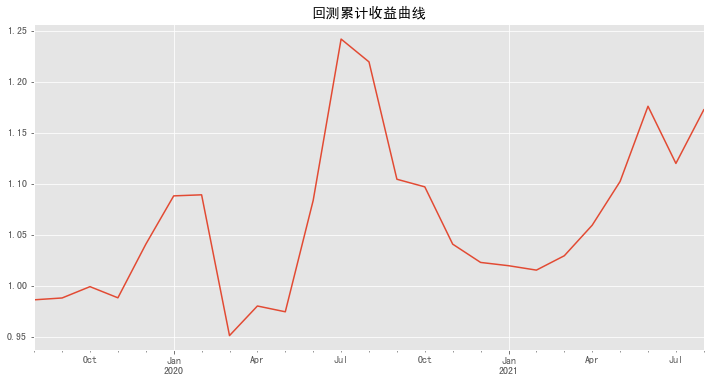

In [16]:
(ret.loc['2019-08-30':] + 1).cumprod().plot(figsize=(12,6), title='回测累计收益曲线')

In [17]:
ann_return = ret.loc['2019-08-30':].mean() * 12 * 100 # 计算年化收益率
ann_vol = ret.loc['2019-08-30':].std() * np.sqrt(12) * 100 # 计算年化波动率

print('年化收益率（非超额）：%.2f%%' % ann_return)
print('年化波动率（非超额）：%.2f%%' % ann_vol)
print('信息比率（非超额）：%.2f' % (ann_return/ann_vol))

年化收益率（非超额）：9.53%
年化波动率（非超额）：19.78%
信息比率（非超额）：0.48


# 三、均线策略 - 双均线

<IPython.core.display.Javascript object>

[[<Figure size 1080x720 with 5 Axes>]]

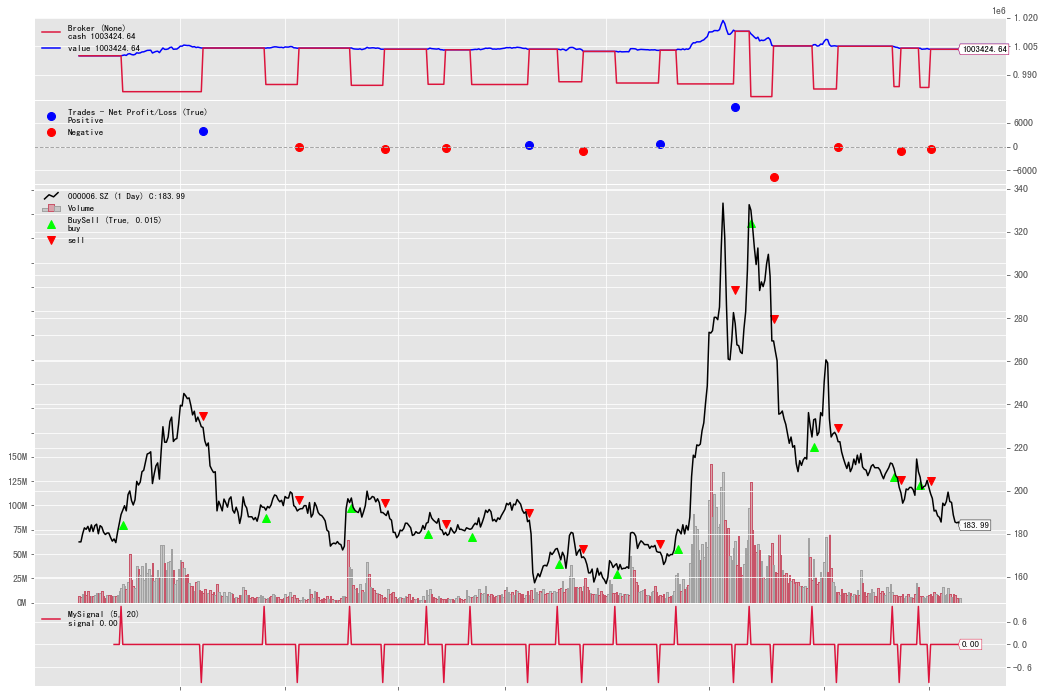

In [153]:
import backtrader as bt

# 自定义信号指标
class MySignal(bt.Indicator):
    lines = ('signal',)  # 声明 signal 线，交易信号放在 signal line 上
    params = dict(
        short_period=5,
        long_period=20)

    def __init__(self):
        self.s_ma = bt.ind.SMA(period=self.p.short_period, plot=True)
        self.l_ma = bt.ind.SMA(period=self.p.long_period, plot=True)
        # 短期均线上穿长期均线，取值为1；反之，短期均线下穿长期均线，取值为-1
        self.lines.signal = bt.ind.CrossOver(self.s_ma, self.l_ma)
        

# 实例化大脑
cerebro = bt.Cerebro()  
# 加载数据
# 读取行情数据 
daily_price = pd.read_csv("./data/daily_price.csv", parse_dates=['datetime'])
stock_name = '000006.SZ'
stock_price = daily_price.query(f"sec_code=='{stock_name}'").set_index('datetime')
datafeed = bt.feeds.PandasData(dataname=stock_price,
                              fromdate=pd.to_datetime('2019-01-02'),  
                              todate=pd.to_datetime('2021-01-28'))    
cerebro.adddata(datafeed, name=stock_name) 
# 初始资金 1,000,000    
cerebro.broker.setcash(1000000.0) 
# 佣金，双边各 0.0003
cerebro.broker.setcommission(commission=0.0003) 
# 滑点：双边各 0.0001
cerebro.broker.set_slippage_perc(perc=0.0001)
#每次固定交易100股
cerebro.addsizer(bt.sizers.FixedSize, stake=100) 
# 添加交易信号
cerebro.add_signal(bt.SIGNAL_LONG, MySignal)
# 回测时需要添加 PyFolio 分析器
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
result = cerebro.run()
cerebro.plot(iplot=False)
# 借助 pyfolio 进一步做回测结果分析


## 四、均线策略 -  三均线

<IPython.core.display.Javascript object>

[[<Figure size 1080x720 with 5 Axes>]]

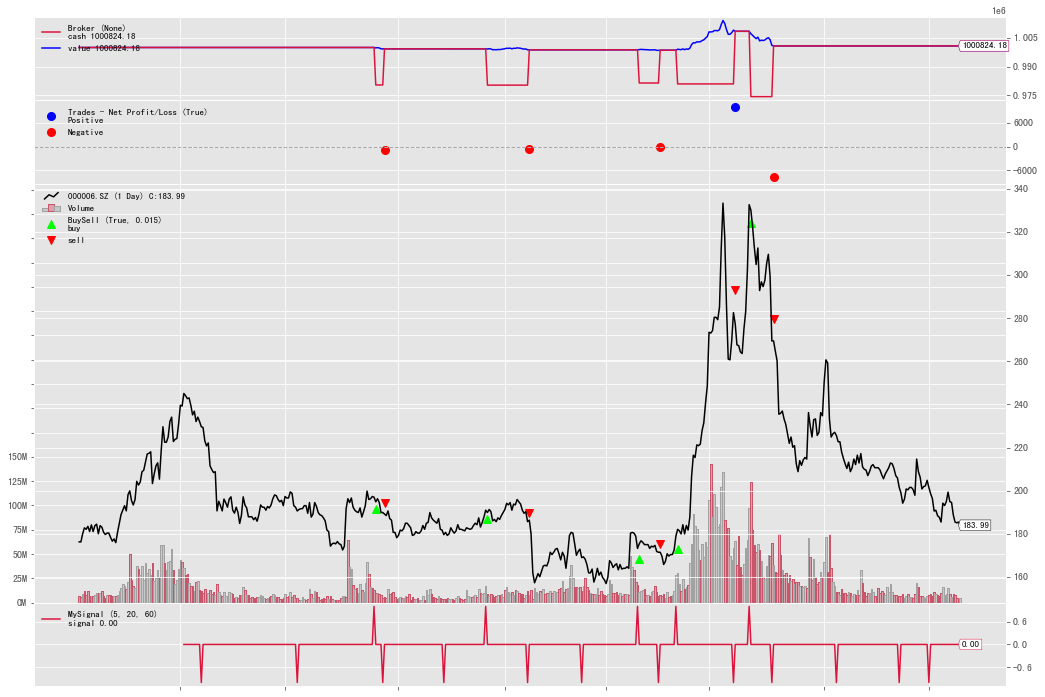

In [154]:
import backtrader as bt

# 自定义信号指标
class MySignal(bt.Indicator):
    lines = ('signal',)  # 声明 signal 线，交易信号放在 signal line 上
    params = dict(
        short_period=5,
        median_period=20,
        long_period=60)
    def __init__(self):
        self.s_ma = bt.ind.SMA(period=self.p.short_period)
        self.m_ma = bt.ind.SMA(period=self.p.median_period)
        self.l_ma = bt.ind.SMA(period=self.p.long_period)
        # 短期均线在中期均线上方，且中期均取也在长期均线上方，三线多头排列，取值为1；反之，取值为0
        self.signal1 = bt.And(self.m_ma>self.l_ma, self.s_ma>self.m_ma)
        # 求上面 self.signal1 的环比增量，可以判断得到第一次同时满足上述条件的时间，第一次满足条件为1，其余条件为0
        self.buy_signal = bt.If((self.signal1-self.signal1(-1))>0, 1, 0)
        # 短期均线下穿长期均线时，取值为1；反之取值为0
        self.sell_signal = bt.ind.CrossDown(self.s_ma, self.m_ma)
        # 将买卖信号合并成一个信号
        self.lines.signal = bt.Sum(self.buy_signal, self.sell_signal*(-1))

# 实例化大脑
cerebro = bt.Cerebro()  
# 加载数据
# 读取行情数据 
daily_price = pd.read_csv("./data/daily_price.csv", parse_dates=['datetime'])
stock_name = '000006.SZ'
stock_price = daily_price.query(f"sec_code=='{stock_name}'").set_index('datetime')
datafeed = bt.feeds.PandasData(dataname=stock_price,
                              fromdate=pd.to_datetime('2019-01-02'),  
                              todate=pd.to_datetime('2021-01-28'))    
cerebro.adddata(datafeed, name=stock_name) 
# 初始资金 1,000,000    
cerebro.broker.setcash(1000000.0) 
# 佣金，双边各 0.0003
cerebro.broker.setcommission(commission=0.0003) 
# 滑点：双边各 0.0001
cerebro.broker.set_slippage_perc(perc=0.0001)
#每次固定交易100股
cerebro.addsizer(bt.sizers.FixedSize, stake=100) 
# 添加交易信号
cerebro.add_signal(bt.SIGNAL_LONG, MySignal)
# 回测时需要添加 PyFolio 分析器
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
result = cerebro.run()
cerebro.plot(iplot=False)
# 借助 pyfolio 进一步做回测结果分析


# 五、海龟交易策略

self.CrossoverL < 0 and self.buy_count == 0
2020-03-02, ref:1028, name: IF, Order: Submitted
2020-03-02, ref:1028, name: IF, Order: Accepted
2020-03-02, SELL EXECUTED, status: Completed, ref:1028, name: IF, Size: -1.00, Price: 3507.80, Cost: 0.10, Comm 0.10
2020-03-02, Trade Opened, name: IF, Size: -1.00,Price: 3507.80
self.CrossoverH>0
2020-04-30, ref:1029, name: IF, Order: Submitted
2020-04-30, ref:1029, name: IF, Order: Accepted
2020-04-30, BUY EXECUTED, status: Completed, ref:1029, name: IF, Size: 1.00, Price: 3440.60, Cost: 0.10, Comm 0.10
2020-04-30, Trade Closed, name: IF, GROSS 20160.00, NET 20159.80, Comm 0.20
if self.CrossoverH > 0 and self.buy_count == 0:
2020-05-11, ref:1030, name: IF, Order: Submitted
2020-05-11, ref:1030, name: IF, Order: Accepted
2020-05-11, BUY EXECUTED, status: Completed, ref:1030, name: IF, Size: 3.00, Price: 3551.60, Cost: 0.30, Comm 0.30
2020-05-11, Trade Opened, name: IF, Size: 3.00,Price: 3551.60
if self.datas[0].close >self.last_price + 0.5*self.

/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-01-02
End date,2022-04-29
Total months,26
,Backtest
Annual return,38.437%
Cumulative returns,106.81%
Annual volatility,92.344%
Sharpe ratio,0.79
Calmar ratio,0.59
Stability,0.06
Max drawdown,-64.997%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,65.00,2020-07-13,2021-12-28,NaT,NaN
1,42.83,2020-03-23,2020-06-15,2020-06-23,67
2,7.91,2020-07-09,2020-07-10,2020-07-13,3
3,7.49,2020-06-24,2020-06-29,2020-06-30,5
4,6.73,2020-02-28,2020-03-05,2020-03-12,10


<IPython.core.display.Javascript object>

/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


Stress Events,mean,min,max
New Normal,0.29%,-24.62%,45.45%


<IPython.core.display.Javascript object>

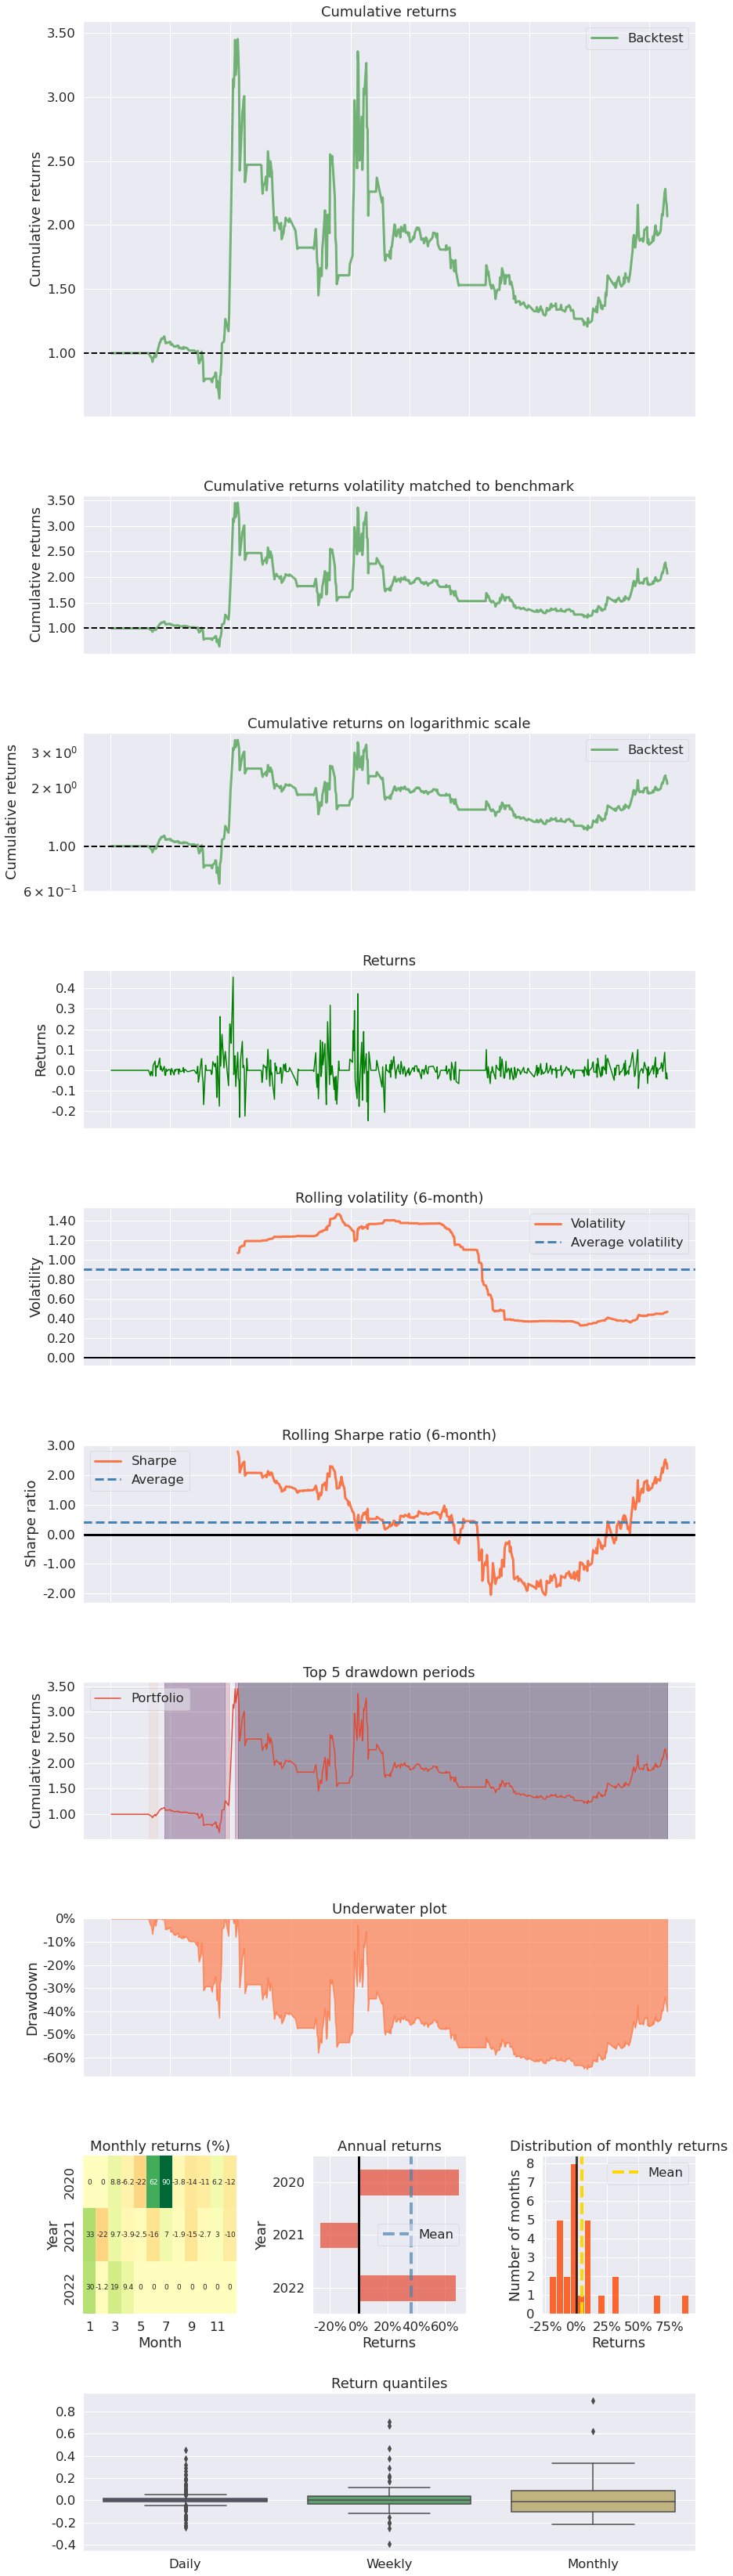

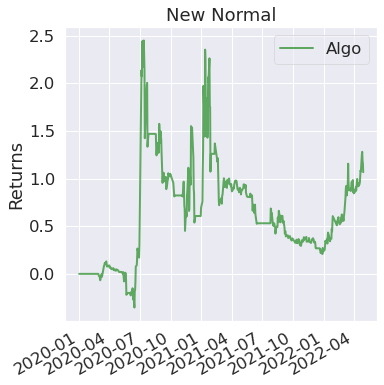

In [10]:

class TurtleTradingStrategy(bt.Strategy):
    params = dict(
        N1= 20, # 唐奇安通道上轨的t
        N2=10, # 唐奇安通道下轨的t
        )  
    
    def log(self, txt, dt=None):           
            dt = dt or self.datas[0].datetime.date(0)           
            print('%s, %s' % (dt.isoformat(), txt))    

    def __init__(self): 
        self.order = None                   
        self.buy_count = 0 # 记录买入次数
        self.last_price = 0 # 记录买入价格
        # 准备第一个标的沪深300主力合约的close、high、low 行情数据   
        self.close = self.datas[0].close
        self.high = self.datas[0].high        
        self.low = self.datas[0].low  
        # 计算唐奇安通道上轨：过去20日的最高价
        self.DonchianH = bt.ind.Highest(self.high(-1), period=self.p.N1, subplot=True)
        # 计算唐奇安通道下轨：过去10日的最低价
        self.DonchianL = bt.ind.Lowest(self.low(-1), period=self.p.N2, subplot=True)  
        # 生成唐奇安通道上轨突破：close>DonchianH，取值为1.0；反之为 -1.0    
        self.CrossoverH = bt.ind.CrossOver(self.close(0), self.DonchianH, subplot=False) 
        # 生成唐奇安通道下轨突破: 
        self.CrossoverL = bt.ind.CrossOver(self.close(0), self.DonchianL, subplot=False)
        # 计算 ATR
        self.TR = bt.ind.Max((self.high(0)-self.low(0)), # 当日最高价-当日最低价
                                    abs(self.high(0)-self.close(-1)), # abs(当日最高价−前一日收盘价)  
                                    abs(self.low(0)-self.close(-1))) # abs(当日最低价-前一日收盘价)   
        self.ATR = bt.ind.SimpleMovingAverage(self.TR, period=self.p.N1, subplot=False)
        # 计算 ATR，直接调用 talib ，使用前需要安装 python3 -m pip install TA-Lib
        # self.ATR = bt.talib.ATR(self.high, self.low, self.close, timeperiod=self.p.N1, subplot=True)   
    
    
    def next(self): 
        # 如果还有订单在执行中，就不做新的仓位调整
        if self.order:
            return  
                
        # 如果当前持有多单
        if self.position.size > 0 :
            # 多单加仓:价格上涨了买入价的0.5的ATR且加仓次数少于等于3次
            if self.datas[0].close >self.last_price + 0.5*self.ATR[0] and self.buy_count <= 4: 
                print('if self.datas[0].close >self.last_price + 0.5*self.ATR[0] and self.buy_count <= 4:')
                print('self.buy_count',self.buy_count)
                # 计算建仓单位：self.ATR*期货合约乘数300*保证金比例0.1
                self.buy_unit = max((self.broker.getvalue()*0.005)/(self.ATR*300*0.1),1)              
                self.buy_unit = int(self.buy_unit)  # 交易单位为手            
                # self.sizer.p.stake = self.buy_unit            
                self.order = self.buy(size=self.buy_unit) 
                self.last_price = self.position.price # 获取买入价格
                self.buy_count = self.buy_count + 1
            #多单止损：当价格回落2倍ATR时止损平仓 
            elif self.datas[0].close < (self.last_price - 2*self.ATR[0]): 
                print('elif self.datas[0].close < (self.last_price - 2*self.ATR[0]):')
                self.order = self.sell(size=abs(self.position.size))
                self.buy_count = 0
            #多单止盈：当价格突破10日最低点时止盈离场 平仓       
            elif self.CrossoverL < 0:  
                print('self.CrossoverL < 0')
                self.order = self.sell(size=abs(self.position.size)) 
                self.buy_count = 0 
                
        # 如果当前持有空单
        elif self.position.size < 0 :
            # 空单加仓:价格小于买入价的0.5的ATR且加仓次数少于等于3次
            if self.datas[0].close<self.last_price-0.5*self.ATR[0] and self.buy_count <= 4:
                print('self.datas[0].close<self.last_price-0.5*self.ATR[0] and self.buy_count <= 4')
                # 计算建仓单位：self.ATR*期货合约乘数300*保证金比例0.1
                self.buy_unit = max((self.broker.getvalue()*0.005)/(self.ATR*300*0.1),1)              
                self.buy_unit = int(self.buy_unit)  # 交易单位为手            
                # self.sizer.p.stake = self.buy_unit            
                self.order = self.sell(size=self.buy_unit) 
                self.last_price = self.position.price # 获取买入价格
                self.buy_count = self.buy_count + 1              
            #空单止损：当价格上涨至2倍ATR时止损平仓
            elif self.datas[0].close < (self.last_price+2*self.ATR[0]): 
                print('self.datas[0].close < (self.last_price+2*self.ATR[0])')
                self.order = self.buy(size=abs(self.position.size)) 
                self.buy_count = 0
            #多单止盈：当价格突破20日最高点时止盈平仓       
            elif self.CrossoverH>0:
                print('self.CrossoverH>0')
                self.order = self.buy(size=abs(self.position.size))            
                self.buy_count = 0
                
        else:  # 如果没有持仓，等待入场时机
            #入场: 价格突破上轨线且空仓时，做多
            if self.CrossoverH > 0 and self.buy_count == 0: 
                print('if self.CrossoverH > 0 and self.buy_count == 0:')
                # 计算建仓单位：self.ATR*期货合约乘数300*保证金比例0.1
                self.buy_unit = max((self.broker.getvalue()*0.005)/(self.ATR*300*0.1),1)          
                self.buy_unit = int(self.buy_unit)  # 交易单位为手 
                self.order = self.buy(size=self.buy_unit)
                self.last_price = self.position.price # 记录买入价格
                self.buy_count = 1  # 记录本次交易价格
            #入场: 价格跌破下轨线且空仓时，做空
            elif self.CrossoverL < 0 and self.buy_count == 0:
                print('self.CrossoverL < 0 and self.buy_count == 0')
                # 计算建仓单位：self.ATR*期货合约乘数300*保证金比例0.1
                self.buy_unit = max((self.broker.getvalue()*0.005)/(self.ATR*300*0.1),1)          
                self.buy_unit = int(self.buy_unit)  # 交易单位为手                                  
                self.order = self.sell(size=self.buy_unit)
                self.last_price = self.position.price # 记录买入价格
                self.buy_count = 1  # 记录本次交易价格
        
    # 打印订单日志
    def notify_order(self, order):
        order_status = ['Created','Submitted','Accepted','Partial',
                        'Completed','Canceled','Expired','Margin','Rejected']
        # 未被处理的订单
        if order.status in [order.Submitted, order.Accepted]:
            self.log('ref:%.0f, name: %s, Order: %s'% (order.ref,
                                                   order.data._name,
                                                   order_status[order.status]))
            return
        # 已经处理的订单
        if order.status in [order.Partial, order.Completed]:
            if order.isbuy():
                self.log(
                        'BUY EXECUTED, status: %s, ref:%.0f, name: %s, Size: %.2f, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order_status[order.status], # 订单状态
                         order.ref, # 订单编号
                         order.data._name,  # 股票名称
                         order.executed.size,  # 成交量
                         order.executed.price, # 成交价
                         order.executed.value, # 成交额
                         order.executed.comm)) # 佣金
            else:  # Sell
                self.log('SELL EXECUTED, status: %s, ref:%.0f, name: %s, Size: %.2f, Price: %.2f, Cost: %.2f, Comm %.2f' %
                            (order_status[order.status],
                             order.ref,
                             order.data._name,
                             order.executed.size,
                             order.executed.price,
                             order.executed.value,
                             order.executed.comm))
                    
        elif order.status in [order.Canceled, order.Margin, order.Rejected, order.Expired]:
            # 订单未完成
            self.log('ref:%.0f, name: %s, status: %s'% (
                order.ref, order.data._name, order_status[order.status]))
            
        self.order = None
        
    def notify_trade(self, trade):
        # 交易刚打开时
        if trade.justopened: 
            self.log('Trade Opened, name: %s, Size: %.2f,Price: %.2f' % (
                    trade.getdataname(), trade.size, trade.price))
        # 交易结束   
        elif trade.isclosed:
            self.log('Trade Closed, name: %s, GROSS %.2f, NET %.2f, Comm %.2f' %(
            trade.getdataname(), trade.pnl, trade.pnlcomm, trade.commission))
        # 更新交易状态
        else: 
            self.log('Trade Updated, name: %s, Size: %.2f,Price: %.2f' % (
                    trade.getdataname(), trade.size, trade.price))
   
  
# 创建主控制器    
cerebro = bt.Cerebro()     
# 准备股票日线数据，输入到backtrader     
IF_price = pd.read_csv('./data/IF_20200101_20220430.csv', parse_dates=['datetime'], index_col=0)
datafeed = bt.feeds.PandasData(dataname=IF_price,
                           fromdate=pd.to_datetime('2020-01-01'),  
                           todate=pd.to_datetime('2022-04-30'))    
cerebro.adddata(datafeed, name='IF')    
# 初始资金 100,000,000   
cerebro.broker.setcash(1000000.0)    
cerebro.broker.setcommission(commission=0.1, # 按 0.1% 来收取手续费
                             mult=300,  # 合约乘数
                             margin=0.1, # 保证金比例
                             percabs=False, # 表示 commission 以 % 为单位
                             commtype=bt.CommInfoBase.COMM_FIXED,
                             stocklike=False)

# 加入策略    
cerebro.addstrategy(TurtleTradingStrategy)     
# 回测时需要添加 PyFolio 分析器
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
result = cerebro.run()
# 借助 pyfolio 进一步做回测结果分析

pyfolio = result[0].analyzers.pyfolio  # 注意：后面不要调用 .get_analysis() 方法
# 或者是 result[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio.get_pf_items()

import pyfolio as pf
pf.create_full_tear_sheet(returns)

# 六、配对交易策略

In [102]:
# step1: 基于收盘价序列，筛选出存在协整关系的股票
daily_price = pd.read_csv("./data/daily_price.csv", parse_dates=['datetime'])
daily_close = daily_price.pivot(index='datetime', columns='sec_code', values='close')
daily_close

sec_code,000006.SZ,000008.SZ,000009.SZ,000012.SZ,000021.SZ,000025.SZ,000027.SZ,000028.SZ,000039.SZ,000046.SZ,...,603866.SH,603868.SH,603877.SH,603882.SH,603883.SH,603885.SH,603888.SH,603939.SH,603983.SH,688088.SH
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-02,176.264930,86.425836,31.664856,94.492762,78.575984,50.158325,69.133085,157.129560,259.909616,151.259432,...,45.789420,39.564276,18.883351,22.050534,46.615162,35.782722,33.326333,82.262756,NaN,NaN
2019-01-03,176.264930,85.534848,31.223021,95.205019,78.022632,50.836140,69.133085,157.441867,256.515274,149.316056,...,46.567623,38.410674,18.914563,21.288095,45.825769,36.221236,33.506475,80.874011,NaN,NaN
2019-01-04,180.029812,87.094077,32.180330,97.341790,79.959364,51.382158,70.072758,157.168598,261.606787,157.413456,...,47.107176,38.709756,19.039411,22.140823,46.973977,35.636551,33.995433,81.915570,NaN,NaN
2019-01-07,182.767908,90.658029,32.769444,98.054047,83.417814,51.570440,70.206997,156.856291,269.850189,157.737352,...,48.217411,39.265194,19.101836,22.933358,47.691606,36.162767,34.381452,81.895147,NaN,NaN
2019-01-08,182.083384,92.217258,33.284918,98.054047,83.417814,52.285911,70.743953,155.568024,271.304907,158.709040,...,48.155155,38.944749,19.153856,21.950213,46.615162,35.431911,34.021168,80.179638,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-22,188.740156,58.261580,68.476057,195.482320,275.595385,44.006618,93.962832,167.617744,566.931100,106.097784,...,85.859965,54.121965,36.639070,169.719500,111.899422,29.085072,50.229980,293.085780,53.854140,62.843659
2021-01-25,185.454544,56.917082,66.522135,190.662208,294.689105,42.720355,96.422592,161.947968,575.259250,104.397499,...,85.316356,54.542837,35.717332,172.813004,115.823677,29.380652,50.361334,295.911120,51.754622,60.490527
2021-01-26,185.089476,56.692999,63.324810,182.093120,282.334345,42.829825,96.586576,155.918840,541.946650,103.377328,...,82.568112,55.532457,34.415378,169.104830,111.768613,30.444740,48.706267,295.565160,51.503484,59.999873


In [122]:
from statsmodels.tsa.stattools import coint   #协整分析的模块
import numpy as np

def find_cointergrated_stocks(data): 
    '''查找股票列表中有协整关系的股票''' 
    cols = data.columns                
    pairs = []
    for i,j in zip(cols[:-1], cols[1:]):
        data_ = data.loc[:,[i,j]].dropna()
        result = coint(data_.loc[:,i],data_.loc[:,j]) # 对两只股票进行协整检验
        if result[1]<0.01: # 当 pvalue 小于 0.01 时，拒绝原假设，股票间存在显著的协整关系
            pairs.append((i,j,result[1]))  #记录存在协整关系的股票
    pairs = sorted(pairs, key=lambda x: x[2])
    return pairs      

pairs = find_cointergrated_stocks(daily_close)
pairs     #打印存在协整关系的股票对

[('600718.SH', '600728.SH', 0.00023094511677972923),
 ('002078.SZ', '002080.SZ', 0.0005976642104313337),
 ('603000.SH', '603025.SH', 0.0010665441586005446),
 ('600939.SH', '600959.SH', 0.001116335965018191),
 ('000685.SZ', '000690.SZ', 0.001134309188955128),
 ('600776.SH', '600777.SH', 0.0014069030209432985),
 ('002375.SZ', '002382.SZ', 0.001593931641995374),
 ('002936.SZ', '002941.SZ', 0.0028652991227114777),
 ('603712.SH', '603737.SH', 0.002914408665798237),
 ('600167.SH', '600169.SH', 0.006705897917002837),
 ('002414.SZ', '002416.SZ', 0.009059104023385636)]

In [118]:
# step2: 对满足协整关系的股票，检验他们是否是同阶单整
# 以 '600718.SH', '600728.SH' 为例
from statsmodels.tsa.stattools import adfuller   # adf检验模块

def test_stationarity(data):
    adftest = adfuller(data)
    result = pd.Series(adftest[0:4],index=['adf','pvalue','lags used','number of pbservations'])
    for key,value in adftest[4].items():
        result['Critical value(%s)'%key] = value
    return result

In [121]:
# 对原序列进行平稳性检验
# 发现在0.01的显著性水平下， 600718.SH 和 600728.SH 都是没有充分的理由拒绝原假设，是非平稳序列
adf = pd.concat([test_stationarity(daily_close.loc[:,'600718.SH']),
                test_stationarity(daily_close.loc[:,'600728.SH'])],
                axis=1)
adf.columns=['600718.SH','600728.SH']
adf

,600718.SH,600728.SH
adf,-3.024686,-2.494081
pvalue,0.032652,0.116921
lags used,18.000000,3.000000
number of pbservations,487.000000,502.000000
Critical value(1%),-3.443849,-3.443444
Critical value(5%),-2.867493,-2.867315
Critical value(10%),-2.569941,-2.569846


In [117]:
# 对一阶差分后的序列进行平稳性检验
# 发现在 0.01 的显著性水平下， 600718.SH 和 600728.SH 都拒绝了原假设，是平稳序列
# 所以两者都是一阶单整
adf = pd.concat([test_stationarity(daily_close.loc[:,'600718.SH'].diff().iloc[1:]),
                test_stationarity(daily_close.loc[:,'600728.SH'].diff().iloc[1:])],
                axis=1)
adf.columns=['600718.SH','600728.SH']
adf

,600718.SH,600728.SH
adf,-6.464446e+00,-1.504180e+01
pvalue,1.416675e-08,9.569124e-28
lags used,1.400000e+01,2.000000e+00
number of pbservations,4.900000e+02,5.020000e+02
Critical value(1%),-3.443766e+00,-3.443444e+00
Critical value(5%),-2.867457e+00,-2.867315e+00
Critical value(10%),-2.569921e+00,-2.569846e+00


<IPython.core.display.Javascript object>

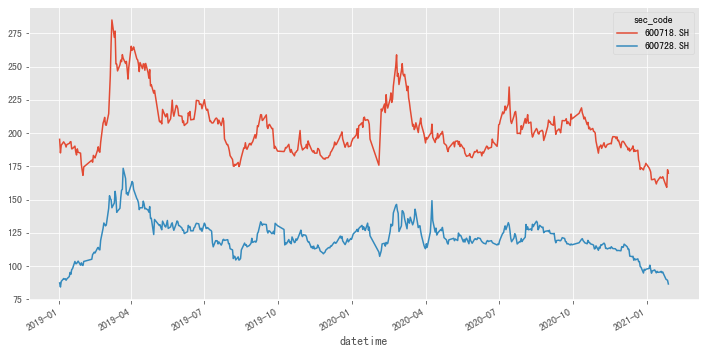

In [123]:
daily_close.loc[:,['600718.SH','600728.SH']].plot(figsize=(12,6))

In [128]:
# step3: 通过ols线性回归来估计双方的长期均衡关系，并得到协整序列
import statsmodels.api as sm

X = sm.add_constant(daily_close.loc[:,'600718.SH']) # 添加常数项
y = daily_close.loc[:,'600728.SH']
res = (sm.OLS(y,X)).fit()
residual = res.resid         #得到估计的残差序列
print(res.summary())               #查看OLS估计结果
print(test_stationarity(residual)) # 查看残差的平稳性

# 回归方程的系数都显示，整个回归方程也显著，而且回归的残差序列也是平稳序列，说明两只股票收盘价序列之间存在稳定的协整关系。
# 协整序列为：y-(13.0407+0.5347*x)，其实就是回归方程的残差

                            OLS Regression Results                            
Dep. Variable:              600728.SH   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     1151.
Date:                Sun, 15 May 2022   Prob (F-statistic):          3.25e-132
Time:                        23:10:39   Log-Likelihood:                -1738.7
No. Observations:                 506   AIC:                             3481.
Df Residuals:                     504   BIC:                             3490.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0407      3.211      4.062      0.0

<IPython.core.display.Javascript object>

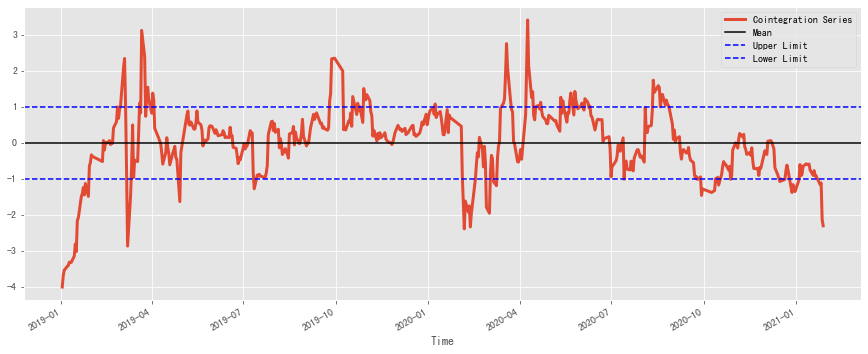

In [138]:
# step4: 基于协整序列构建配对交易策略
# 对协整序列进行 z−score 标准化处理，得到的 z−score 表示协整序列偏离了其均值多少倍的标准差
# 当 z−score>1 则认为 Y 取值相对过高，x 取值相对过低，即 Y 的价格相对高估，x 的价格相对低估，此时应该做多x，做空Y；
# 当 z−score<-1 则认为 Y 取值相对过低，x 取值相对过高，即 Y 的价格相对低估，x 的价格相对高估，此时应该做空x,做多Y。

import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
z_score = (residual - residual.mean())/ residual.std()  #将协整序列标准化处理
z_score.plot(linewidth=3)
plt.axhline(0, color="black")   #标准化后均值为0
plt.axhline(1.0, color="blue", linestyle='--')   #均值以上1个标准差作为上限
plt.axhline(-1.0, color="blue", linestyle='--')   #均值以下1个标准差作为下限
plt.xlabel("Time")
plt.legend(["Cointegration Series", "Mean", "Upper Limit", "Lower Limit"],loc = "upper right")
plt.show()


-2.4133406060706126 -1 0
(self.zscore[0] < self.lower_limit) and (self.status != 2)
2019-01-30, ref:5503, name: 600718.SH, Order: Submitted
2019-01-30, ref:5504, name: 600728.SH, Order: Submitted
2019-01-30, ref:5503, name: 600718.SH, Order: Accepted
2019-01-30, ref:5504, name: 600728.SH, Order: Accepted
2019-01-30, BUY EXECUTED, status: Completed, ref:5503, name: 600718.SH, Size: 100.00, Price: 176.95, Cost: 17695.44, Comm 5.31
2019-01-30, SELL EXECUTED, status: Completed, ref:5504, name: 600728.SH, Size: -100.00, Price: 101.22, Cost: -10121.70, Comm 3.04
2019-01-30, Trade Opened, name: 600718.SH, Size: 100.00,Price: 176.95
2019-01-30, Trade Opened, name: 600728.SH, Size: -100.00,Price: 101.22
0.4167166867897186 0.5 -0.5
(self.zscore[0] <= self.up_medium) and (self.zscore[0] >= self.low_medium)
2019-02-12, ref:5505, name: 600718.SH, Order: Submitted
2019-02-12, ref:5506, name: 600728.SH, Order: Submitted
2019-02-12, ref:5505, name: 600718.SH, Order: Accepted
2019-02-12, ref:5506, name

<IPython.core.display.Javascript object>

[[<Figure size 1080x720 with 7 Axes>]]

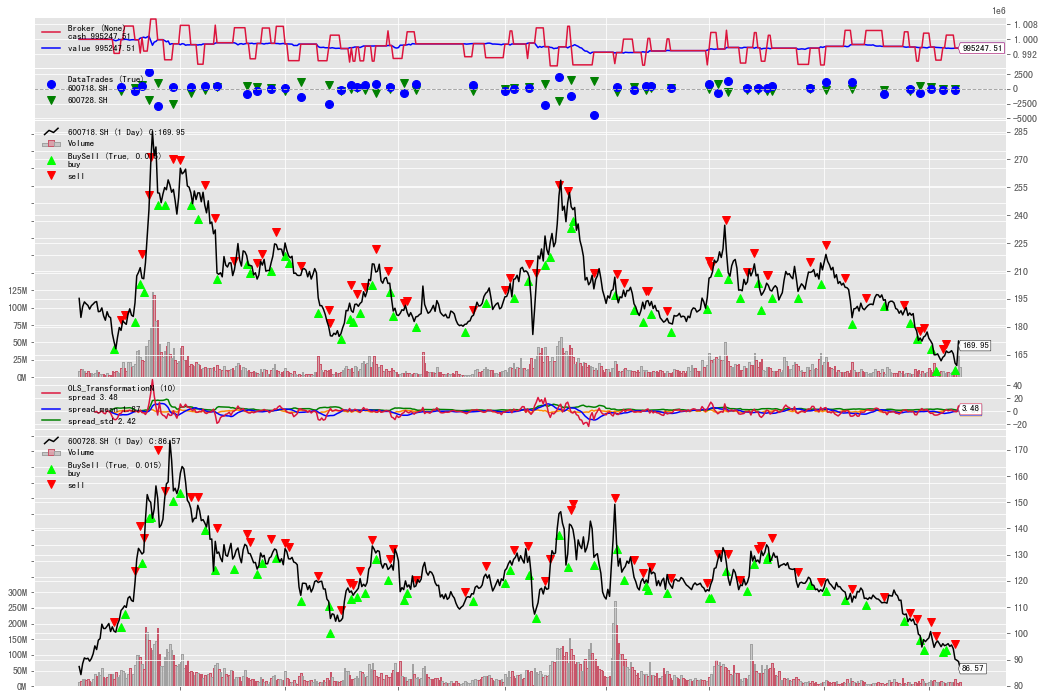

In [155]:

import backtrader as bt

class PairTradingStrategy(bt.Strategy):
    params = dict(
        period=10, # z-score标准化处理时对应的时间窗口
        upper=1,
        lower=-1,
        up_medium=0.5,
        low_medium=-0.5,
    )
    
    def log(self, txt, dt=None):           
        dt = dt or self.datas[0].datetime.date(0)           
        print('%s, %s' % (dt.isoformat(), txt))  

    def __init__(self):
        # To control operation entries
        self.order = None
        self.upper_limit = self.p.upper
        self.lower_limit = self.p.lower
        self.up_medium = self.p.up_medium
        self.low_medium = self.p.low_medium
        self.status = 0

        # 通过ols拟合协整关系，并对协整序列进行z-score标准化处理，返回z-score值
        # self.data0 为 y ; self.data1 为 X
        self.transform = bt.ind.OLS_TransformationN(self.data0, 
                                                    self.data1,
                                                    period=self.p.period)
        self.zscore = self.transform.zscore

    
    def next(self):
        # 如果订单还未完成，则不生成新订单
        if self.order:
            return  

        # 如果 zscore 超过上线，说明 y=data0 的价格相对高估，x=data1 的价格相对低估，此时应该做多x，做空Y；
        if (self.zscore[0] > self.upper_limit) and (self.status != 1):
            print(self.zscore[0], self.upper_limit, self.status)
            print('self.zscore[0] > self.upper_limit) and (self.status != 1)')
            # 做空data0
            self.sell(data=self.data0)
            # 做多data1
            self.buy(data=self.data1)  
            self.status = 1  # 处于 zscore 超过上线 的状态，标记为 1

        # 如果 zscore 跌破下线，说明 y=data0 的价格相对低估，x=data1 的价格相对高估，此时应该做空x，做多Y；
        elif (self.zscore[0] < self.lower_limit) and (self.status != 2):
            print(self.zscore[0], self.lower_limit, self.status)
            print('(self.zscore[0] < self.lower_limit) and (self.status != 2)')
            # 做多data0
            self.buy(data=self.data0) 
            # 做空data1
            self.sell(data=self.data1)  
            self.status = 2 # 处于 zscore 跌破下线的状况，标记为 2

        # 如果 zscore 位于中间区域，认为已经不存在套利空间，则退出所有头寸
        elif (self.zscore[0] <= self.up_medium) and (self.zscore[0] >= self.low_medium):
            print(self.zscore[0], self.up_medium, self.low_medium)
            print('(self.zscore[0] <= self.up_medium) and (self.zscore[0] >= self.low_medium)')
            self.close(self.data0)
            self.close(self.data1)

    def stop(self):
        print('==================================================')
        print('Starting Value - %.2f' % self.broker.startingcash)
        print('Ending   Value - %.2f' % self.broker.getvalue())
        print('==================================================')


    # 打印订单日志
    def notify_order(self, order):
        order_status = ['Created','Submitted','Accepted','Partial',
                        'Completed','Canceled','Expired','Margin','Rejected']
        # 未被处理的订单
        if order.status in [order.Submitted, order.Accepted]:
            self.log('ref:%.0f, name: %s, Order: %s'% (order.ref,
                                                   order.data._name,
                                                   order_status[order.status]))
            return
        # 已经处理的订单
        if order.status in [order.Partial, order.Completed]:
            if order.isbuy():
                self.log(
                        'BUY EXECUTED, status: %s, ref:%.0f, name: %s, Size: %.2f, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order_status[order.status], # 订单状态
                         order.ref, # 订单编号
                         order.data._name,  # 股票名称
                         order.executed.size,  # 成交量
                         order.executed.price, # 成交价
                         order.executed.value, # 成交额
                         order.executed.comm)) # 佣金
            else:  # Sell
                self.log('SELL EXECUTED, status: %s, ref:%.0f, name: %s, Size: %.2f, Price: %.2f, Cost: %.2f, Comm %.2f' %
                            (order_status[order.status],
                             order.ref,
                             order.data._name,
                             order.executed.size,
                             order.executed.price,
                             order.executed.value,
                             order.executed.comm))
                    
        elif order.status in [order.Canceled, order.Margin, order.Rejected, order.Expired]:
            # 订单未完成
            self.log('ref:%.0f, name: %s, status: %s'% (
                order.ref, order.data._name, order_status[order.status]))
            
        self.order = None

    def notify_trade(self, trade):
        # 交易刚打开时
        if trade.justopened: 
            self.log('Trade Opened, name: %s, Size: %.2f,Price: %.2f' % (
                    trade.getdataname(), trade.size, trade.price))
        # 交易结束   
        elif trade.isclosed:
            self.log('Trade Closed, name: %s, GROSS %.2f, NET %.2f, Comm %.2f' %(
            trade.getdataname(), trade.pnl, trade.pnlcomm, trade.commission))
        # 更新交易状态
        else: 
            self.log('Trade Updated, name: %s, Size: %.2f,Price: %.2f' % (
                    trade.getdataname(), trade.size, trade.price))
    
# 实例化大脑
cerebro = bt.Cerebro()  
# 加载数据
# 读取行情数据 
daily_price = pd.read_csv("./data/daily_price.csv", parse_dates=['datetime'])
for stock_name in ['600718.SH','600728.SH']:
    stock_price = daily_price.query(f"sec_code=='{stock_name}'").set_index('datetime')
    datafeed = bt.feeds.PandasData(dataname=stock_price,
                                   fromdate=pd.to_datetime('2019-01-02'),  
                                   todate=pd.to_datetime('2021-01-28'))    
    cerebro.adddata(datafeed, name=stock_name) 
# 初始资金 1,000,000    
cerebro.broker.setcash(1000000.0) 
# 佣金，双边各 0.0003
cerebro.broker.setcommission(commission=0.0003) 
# 滑点：双边各 0.0001
cerebro.broker.set_slippage_perc(perc=0.0001)
#每次固定交易100股
cerebro.addsizer(bt.sizers.FixedSize, stake=100) 
# 添加交易信号
cerebro.addstrategy(PairTradingStrategy)
# 回测时需要添加 PyFolio 分析器
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
result = cerebro.run()
cerebro.plot()
# 借助 pyfolio 进一步做回测结果分析

## 对商品期货套利的伪代码

In [ ]:

class PairTradingStrategy(bt.Strategy):
    params = dict(
        window1=10, # 价差的短期移动均线
        window2=60, # 价差的长期移动均线
        upper=1,
        lower=-1,
        up_medium=0.5,
        low_medium=-0.5,
    )
    def __init__(self):
        self.status = 0
        spread = self.data0.close / self.data1.close
        self.spread_ma1 = bt.ind.SMA(spread, period=self.p.window1)
        self.spread_ma2 = bt.ind.SMA(spread, period=self.p.window2)
        self.spread_std = bt.ind.StdDev(spread, period=self.p.window2)
        self.zscore = (self.spread_ma1 - self.spread_ma2) / self.spread_std
    
    def next(self):
        # 如果 z-score>1 时，做空价格高的data0，做多价格低的data1；
        if (self.zscore[0] > self.upper_limit) and (self.status != 1):
            # 做空data0
            self.sell(data=self.data0)
            # 做多data1
            self.buy(data=self.data1)
            self.status = 1  # 处于 zscore 超过上线 的状态，标记为 1
        # 如果 z-score<-1 时，做多价格低的data0，做空价格高的data1；
        elif (self.zscore[0] < self.lower_limit) and (self.status != 2):
            # 做多data0
            self.buy(data=self.data0) 
            # 做空data1
            self.sell(data=self.data1)  
            self.status = 2 # 处于 zscore 跌破下线的状况，标记为 2

        # 如果 zscore 位于中间区域，认为已经不存在套利空间，则退出所有头寸
        elif (self.zscore[0] <= self.up_medium) and (self.zscore[0] >= self.low_medium):
            self.close(self.data0)
            self.close(self.data1)
